In [1]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names = ["上衣","褲子","套衫","連衣裙","外套","涼鞋","襯衫","運動鞋","袋子","踝靴"]

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, utils, layers, models, optimizers, metrics

seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:

def data_scale_down(train, test, scale):
    (x_train,y_train),(x_test,y_test) = train, test
    num_train = len(x_train)
    num_test = len(x_test)
    train_size = num_train // scale
    test_size = num_test // scale
    x_train, y_train = x_train[:train_size], y_train[:train_size]
    x_test, y_test = x_test[:test_size], y_test[:test_size]
    return (x_train,y_train), (x_test,y_test)

def data_normalize(train, test):
    (x_train,y_train),(x_test,y_test) = train, test
    x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.
    # [b, 28, 28] => [b, 28, 28, 1]
    x_train, x_test = np.expand_dims(x_train,axis=3), np.expand_dims(x_test,axis=3)
    y_train, y_test = utils.to_categorical(y_train), utils.to_categorical(y_test)
    
    return (x_train,y_train),(x_test,y_test)    
    
def fashion_dataset():
    (x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()
    (x_train,y_train), (x_test,y_test) = data_scale_down((x_train,y_train), (x_test,y_test),10)
    (x_train,y_train), (x_test,y_test) = data_normalize((x_train,y_train), (x_test,y_test))
    print("x_train.shape",x_train.shape)
    print("y_train.shape",y_train.shape)
    print("x_test.shape",x_test.shape)
    print("y_test.shape",y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)    


(x_train,y_train),(x_test,y_test) = fashion_dataset()    

x_train.shape (6000, 28, 28, 1)
y_train.shape (6000, 10)
x_test.shape (1000, 28, 28, 1)
y_test.shape (1000, 10)


labels:	    9003027255
labels:	    踝靴  上衣  上衣  連衣裙  上衣  套衫  運動鞋  套衫  涼鞋  涼鞋  

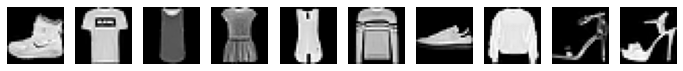

In [4]:
print("labels:\t    ",end="")
for label in y_train[0:10]:
    print(label.argmax(axis=0),end="")
print("\nlabels:\t    ",end="")
for label in y_train[0:10]:
    index = label.argmax(axis=0)
    print(class_names[index]," ",end="")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [42]:
#del ResnetBlock
class ResnetBlock(models.Model):
    def __init__(self, channels, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.channels = channels
        self.strides = strides
        self.residual_path = residual_path
        self.model = self.create_model()        
        
    def create_model(self):
        model = models.Sequential()
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(self.channels, strides=self.strides, kernel_size=(3,3), activation="relu", padding="same",
                                use_bias=False, kernel_initializer=tf.random_normal_initializer))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(self.channels, kernel_size=(3,3), activation="relu", padding="same",
                                use_bias=False, kernel_initializer=tf.random_normal_initializer))
        
        if self.residual_path:
            resi_model = models.Sequential()
            resi_model.add(layers.BatchNormalization())
            resi_model.add(layers.Conv2D(self.channels, strides=self.strides, kernel_size=(1,1), activation="relu"))           
            self.resi_model = resi_model
            
        return model
    
    def call(self, inputs):
        # residual 殘留的；剩餘的
        residual = inputs
        x = self.model(inputs)        
        if self.residual_path:
            residual = self.resi_model(inputs)
        x = x + residual
        
        return x

In [43]:
#del ResNet
# model = ResNet([2, 2, 2], num_classes)
class ResNet(models.Model):    
    def __init__(self, block_list, num_classes, initial_filters=16, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        self.num_blocks = len(block_list)
        self.block_list = block_list
        self.num_classes = num_classes
        self.in_channels = initial_filters
        self.out_channels = initial_filters
        self.model = self.create_model()
        
    def call(self, inputs):
        outputs = self.model(inputs)
        return outputs
    
    def create_model(self):
        model = models.Sequential()
        model.add(layers.Input(shape=(28, 28, 1)))
        model.add(layers.Conv2D(filters=self.out_channels, kernel_size=(3,3), padding="same",
                                use_bias=False, kernel_initializer=tf.random_normal_initializer))
        
        for block_id in range(self.num_blocks):
            for layer_id in range(self.block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResnetBlock(self.out_channels, strides=2, residual_path=True)
                else:
                    if self.in_channels != self.out_channels:
                        residual_path = True
                    else:
                        residual_path = False
                    block = ResnetBlock(self.out_channels, residual_path=residual_path)
                self.inchannels = self.out_channels
                model.add(block)
            self.out_channels *= 2
            
        model.add(layers.BatchNormalization())                         
        model.add(layers.ReLU())
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(units=self.num_classes))
        return model
    


In [44]:
num_classes = 10
model = ResNet([2, 2, 2], num_classes)

def train():
    batch_size = 32
    epochs = 1    
    model.compile(optimizer=optimizers.Adam(0.05),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    #model.build(input_shape=(None, 28, 28, 1))
    print("Number of variables in the model.model :", len(model.model.variables))
    print("Number of layers in the model.model :", len(model.model.layers))
    ## 'NoneType' object has no attribute 'history'
    #print("loss: {:.4f}".format(history.history["loss"]))
    #print("acc: {:.4f}".format(history.history["accuracy"]))
    
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test,y_test),
              verbose=2)
    
    model.summary()
    scores = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=2)
    print("Final test loss and accuracy :", scores)
    
train()

Number of variables in the model.model : 91
Number of layers in the model.model : 11
Train on 6000 samples, validate on 1000 samples
6000/6000 - 70s - loss: 1.1920 - accuracy: 0.5613 - val_loss: 34.1336 - val_accuracy: 0.1330
Model: "res_net_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_122 (Sequential)  (None, 10)                181594    
Total params: 181,594
Trainable params: 180,378
Non-trainable params: 1,216
_________________________________________________________________
1000/1 - 2s - loss: 36.7758 - accuracy: 0.1330
Final test loss and accuracy : [34.133604858398435, 0.133]


predictions:4222222249
predictions:外套  套衫  套衫  套衫  套衫  套衫  套衫  套衫  外套  踝靴  
labels:	    踝靴  套衫  褲子  褲子  襯衫  褲子  外套  襯衫  涼鞋  運動鞋  

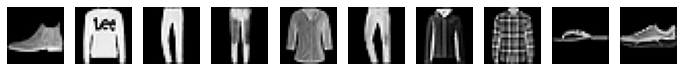

In [50]:
predictions = model.predict(x_test[:10])
print("predictions:",end="")
for predict in predictions:
    print(predict.argmax(axis=0),end="")
print("\npredictions:",end="")
for predict in predictions:
    index = predict.argmax(axis=0) 
    print(class_names[index]," ",end="")      
print("\nlabels:\t    ",end="")
for label in y_test[0:10]:
    index = label.argmax(axis=0)
    print(class_names[index]," ",end="")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.imshow(x_test[i], cmap="gray")
    plt.axis("off")
plt.show()